# Notebook #4: Analysis of the Response (ML)
- Response generated from a synthetic function
- Trials sampled with Definitive Screening design
- Analysis done using the Machine Learning library `scikit-learn`, to find the coefficients from a general 2nd order polynomium using the method `LassoLars`

Note that we need to augment the DSD with 6 fake factors (i.e., 12 more trials than the minimal 14-trials DSD) to obtain a decent agreement with the coefficient of the true synthetic function, but still there are many effects that are neglected or quantified with a large error. However, the predictive power on the test set is pretty satisfying.

Try to play with `n_fake_factors` or LassoLars' `alpha` to improve the model such that it can correctly discriminate the diferent effects (or try to reduce the `noise` in the response).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import definitive_screening_design as dsd

# Need for `pip install scikit-learn`.  This library is needed to perform the linear model fit. 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoLars
from sklearn.pipeline import Pipeline

In [2]:
def add_response(df, noise=5):
    """Generate a synthetic response for a numpy array with 6 factors."""
    x = (
        df
        .drop(columns="Response", errors='ignore')
        .to_numpy()
    )
    df['Response'] = sum([
        # Intercept
        20.0 * np.ones(shape=x.shape[0]),
        # Main Effects
        10.0 * x[:, 0], # X01
         8.0 * x[:, 1], # X02
         6.0 * x[:, 2], # X03
         0.0 * x[:, 3], # X04
         6.0 * x[:, 4], # C01
         0.0 * x[:, 5], # C02
        # 2-Interactions
         8.0 * x[:, 0] * x[:, 1], # X01 * X02
        15.0 * x[:, 1] * x[:, 2], # X02 * X03
        10.0 * x[:, 1] * x[:, 4], # X02 * C01
        # Quadratic
         5.0 * x[:, 0] * x[:, 0], # X01^2
        10.0 * x[:, 3] * x[:, 3], # X04^2
        # Experimental error  
        np.random.normal(0, noise, size=x.shape[0])
    ]).round(1)

In [3]:
A = dsd.generate(n_num=4, n_cat=2, n_fake_factors=6) # Generate the Definitive Screening design (pd.DataFrame) - using 6 fake factors, i.e., 12 extra trials
A = A.replace({"A":0, "B":1}).astype("float")        # Replace the Categorical levels A and B with 0 and 1, and convert to float
add_response(A, noise=5)                             # Compute the synthetic response
A

Generating a Definitive Screening Design with 4 numerical and 2 categorical factors.


,X01,X02,X03,X04,C01,C02,Response
1,0.0,1.0,1.0,1.0,1.0,1.0,73.8
2,0.0,-1.0,-1.0,-1.0,0.0,0.0,28.6
3,1.0,0.0,-1.0,1.0,0.0,1.0,32.9
4,-1.0,0.0,1.0,-1.0,1.0,0.0,30.0
5,1.0,1.0,0.0,-1.0,1.0,0.0,70.5
6,-1.0,-1.0,0.0,1.0,0.0,1.0,26.1
7,1.0,-1.0,1.0,0.0,1.0,1.0,17.5
8,-1.0,1.0,-1.0,0.0,0.0,0.0,-3.4
9,1.0,1.0,-1.0,1.0,1.0,1.0,53.0
10,-1.0,-1.0,1.0,-1.0,0.0,0.0,13.2


In [4]:
X_df = A[["X01", "X02", "X03", "X04", "C01","C02"]]
y_df = A[["Response"]]
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(
        degree=2,
        interaction_only=False,
        include_bias=True
    )),
    ('estimator', LassoLars(
        alpha=1.0,            # Using the default value of scikit-learn: need for hypertuning! 
        normalize=False
    ))
])

pipe.fit(X_df, y_df)
df = pd.DataFrame(
    pipe[-1].coef_.copy().reshape(1,-1), 
    columns=["(1) X1 X2 X3 X4 C1 C2 X1^2 X1X2 X1X3 X1X4 X1C1 X1C2 X2^2 X2X3 X2X4 X2C1 X2C2 X3^2 X3X4 X2C1 X3C2 X4^2 X4C1 X4C2 C1^2 C1C2 C2^2".split(" ")],
    index=['Fit'],
).T
df.loc["(1)", "Fit"] = pipe[-1].intercept_
df['synthetic'] = [20., 10, 8, 6, 0, 6, 0, 5, 8, 0, 0, 0, 0, 0, 15, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0]
df

,Fit,synthetic
(1),32.279975,20.0
X1,8.400341,10.0
X2,10.736722,8.0
X3,5.397186,6.0
X4,0.000000,0.0
C1,2.943743,6.0
C2,0.244524,0.0
X1^2,0.000000,5.0
X1X2,6.713075,8.0
X1X3,0.000000,0.0


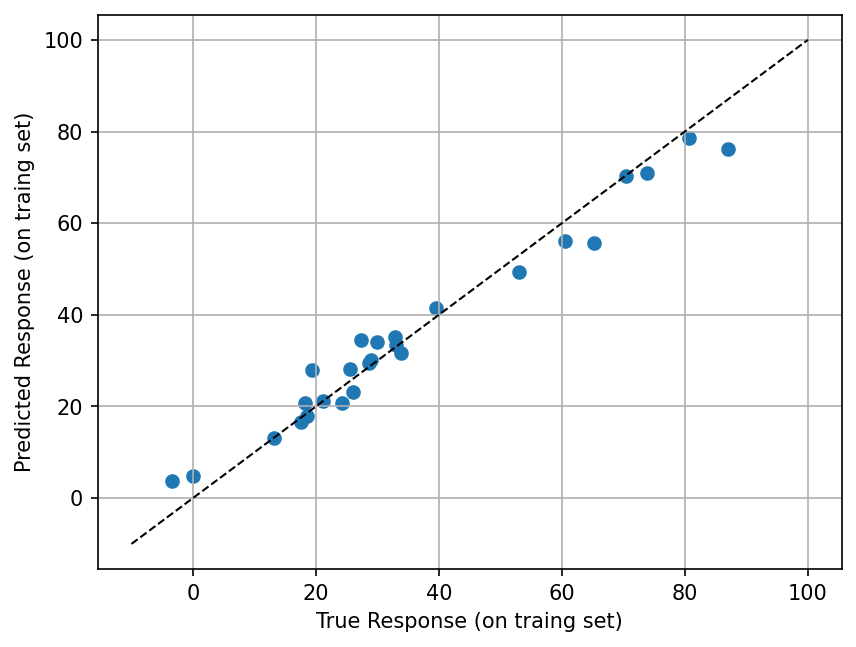

In [5]:
plt.figure(dpi=150)
plt.scatter(y_df, pipe.predict(X_df))
plt.plot([-10,100],[-10, 100], ls="--", lw=1, c='k')
plt.xlabel("True Response (on traing set)")
plt.ylabel("Predicted Response (on traing set)")
plt.grid()
plt.show()

Note that despide the effects are not very well identified, the overall prediction of the response is pretty good.

Let's see if the model has also a good predictive power on a test set generated in the same design space with the same synthetic function:


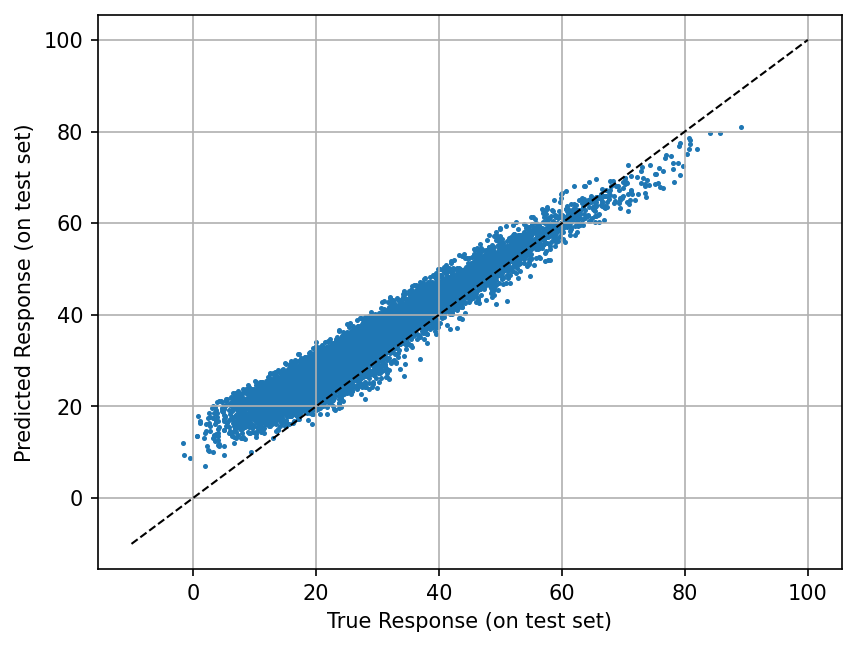

In [6]:
A_test = pd.DataFrame()
for i in [1,2,3,4]:
    A_test[f"X0{i}"] = np.random.uniform(-1, 1, 10000)
for i in [1,2]:
    A_test[f"C0{i}"] = np.random.choice([0,1], 10000)
y_test_pred = pipe.predict(A_test)
add_response(A_test, noise=0)         # Checking the noiseless response to see if the model could correctly strip out the noise
A_test['Prediction'] = y_test_pred

plt.figure(dpi=150)
plt.scatter(A_test['Response'], A_test['Prediction'], s=2)
plt.plot([-10,100],[-10, 100], ls="--", lw=1, c='k')
plt.xlabel("True Response (on test set)")
plt.ylabel("Predicted Response (on test set)")
plt.grid()
plt.show()

Graph of the Lasso path using LARS. Each color represents a different feature of the coefficient vector, and this is displayed as a function of the regularization parameter.

Reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html


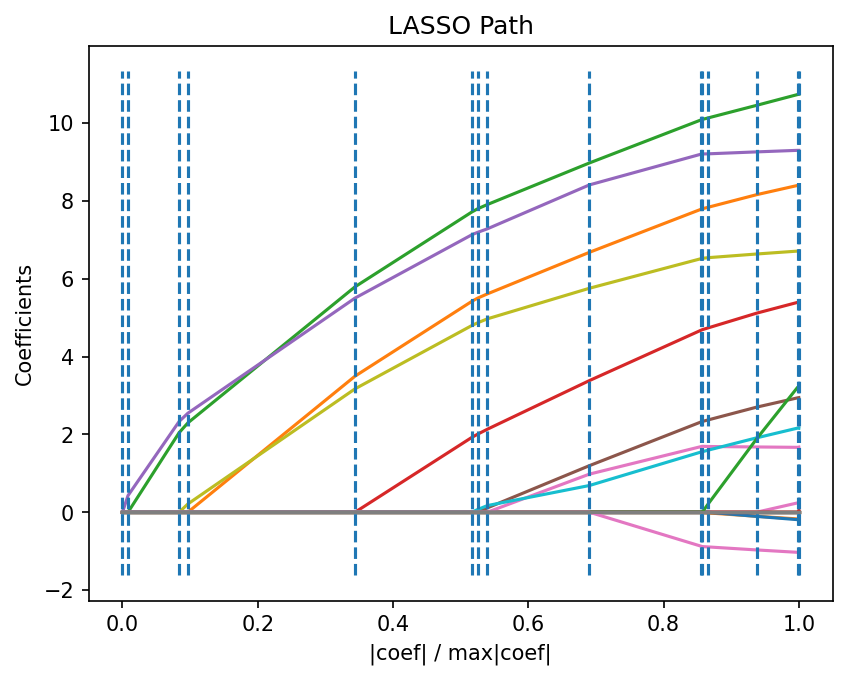

In [7]:
coefs = pipe[-1].coef_path_

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(dpi=150)
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.show()